In [8]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Directory containing audio files
audio_directory = r'AudioWAV'

# Initialize lists to store features and labels
extracted_features = []
emotion_labels = []

# Map emotion codes to their full emotion names
emotion_mapping = {
    'ANG': 'Anger',
    'DIS': 'Disgust',
    'FEA': 'Fear',
    'HAP': 'Happy',
    'NEU': 'Neutral',
    'SAD': 'Sad'
}

# Loop through each audio file in the specified directory
for audio_file in os.listdir(audio_directory):
    if audio_file.endswith(".wav"):  # Process only .wav files
        file_path = os.path.join(audio_directory, audio_file)
        
        # Load the audio file
        audio_signal, sampling_rate = librosa.load(file_path)
        
        # Frame properties (20ms frames with 50% overlap)
        frame_duration = 0.02  # Duration of each frame in seconds
        frame_samples = int(frame_duration * sampling_rate)  # Number of samples in each frame
        hop_samples = frame_samples // 2  # Hop length for 50% overlap
        
        # Compute MFCC features and their statistics
        mfcc_coefficients = librosa.feature.mfcc(
            y=audio_signal, sr=sampling_rate, n_mfcc=13, 
            hop_length=hop_samples, n_fft=frame_samples
        )
        mfcc_stats = np.concatenate([
            np.mean(mfcc_coefficients, axis=1), np.median(mfcc_coefficients, axis=1),
            np.std(mfcc_coefficients, axis=1), skew(mfcc_coefficients, axis=1),
            kurtosis(mfcc_coefficients, axis=1), np.amax(mfcc_coefficients, axis=1),
            np.amin(mfcc_coefficients, axis=1)
        ])

        # Compute RMS energy and its statistics
        rms_energy = librosa.feature.rms(
            y=audio_signal, hop_length=hop_samples, frame_length=frame_samples
        )
        rms_stats = [
            np.mean(rms_energy), np.median(rms_energy), np.std(rms_energy),
            skew(rms_energy, axis=1)[0], kurtosis(rms_energy, axis=1)[0]
        ]

        # Compute Chroma STFT features and their statistics
        chroma_features = librosa.feature.chroma_stft(
            y=audio_signal, sr=sampling_rate, hop_length=hop_samples, n_fft=frame_samples
        )
        chroma_stats = [
            np.mean(chroma_features), np.median(chroma_features), np.std(chroma_features),
            skew(chroma_features, axis=None), kurtosis(chroma_features, axis=None)
        ]

        # Compute spectral centroid and its statistics
        spectral_centroid = librosa.feature.spectral_centroid(
            y=audio_signal, sr=sampling_rate, hop_length=hop_samples, n_fft=frame_samples
        )
        centroid_stats = [
            np.mean(spectral_centroid), np.median(spectral_centroid), np.std(spectral_centroid),
            skew(spectral_centroid, axis=1)[0], kurtosis(spectral_centroid, axis=1)[0]
        ]

        # Compute spectral bandwidth and its statistics
        spectral_bandwidth = librosa.feature.spectral_bandwidth(
            y=audio_signal, sr=sampling_rate, hop_length=hop_samples, n_fft=frame_samples
        )
        bandwidth_stats = [
            np.mean(spectral_bandwidth), np.median(spectral_bandwidth), np.std(spectral_bandwidth),
            skew(spectral_bandwidth, axis=1)[0], kurtosis(spectral_bandwidth, axis=1)[0]
        ]

        # Compute spectral rolloff and its statistics
        spectral_rolloff = librosa.feature.spectral_rolloff(
            y=audio_signal, sr=sampling_rate, hop_length=hop_samples, n_fft=frame_samples
        )
        rolloff_stats = [
            np.mean(spectral_rolloff), np.median(spectral_rolloff), np.std(spectral_rolloff),
            skew(spectral_rolloff, axis=1)[0], kurtosis(spectral_rolloff, axis=1)[0]
        ]

        # Compute zero crossing rate and its statistics
        zero_crossing_rate = librosa.feature.zero_crossing_rate(
            audio_signal, hop_length=hop_samples, frame_length=frame_samples
        )
        zcr_stats = [
            np.mean(zero_crossing_rate), np.median(zero_crossing_rate), np.std(zero_crossing_rate),
            skew(zero_crossing_rate, axis=1)[0], kurtosis(zero_crossing_rate, axis=1)[0]
        ]

        # Combine all features into a single array
        combined_stats = np.concatenate([
            mfcc_stats, rms_stats, chroma_stats, centroid_stats, 
            bandwidth_stats, rolloff_stats, zcr_stats
        ])
        
        extracted_features.append(combined_stats)

        # Extract emotion label from the filename
        filename_parts = audio_file.split('_')
        emotion_code = filename_parts[2]  # Extract emotion code (e.g., ANG, DIS)
        
        # Map the emotion code to its corresponding label
        emotion_label = emotion_mapping.get(emotion_code, "Unknown")
        emotion_labels.append(emotion_label)

# Define column names for the feature DataFrame
mfcc_columns = [f'mfcc_mean_{i}' for i in range(13)] + [f'mfcc_median_{i}' for i in range(13)] + \
               [f'mfcc_std_{i}' for i in range(13)] + [f'mfcc_skew_{i}' for i in range(13)] + \
               [f'mfcc_kurtosis_{i}' for i in range(13)] + [f'mfcc_max_{i}' for i in range(13)] + [f'mfcc_min_{i}' for i in range(13)]

feature_columns = ['rms_mean', 'rms_median', 'rms_std', 'rms_skew', 'rms_kurtosis',
                   'chroma_mean', 'chroma_median', 'chroma_std', 'chroma_skew', 'chroma_kurtosis',
                   'centroid_mean', 'centroid_median', 'centroid_std', 'centroid_skew', 'centroid_kurtosis',
                   'bandwidth_mean', 'bandwidth_median', 'bandwidth_std', 'bandwidth_skew', 'bandwidth_kurtosis',
                   'rolloff_mean', 'rolloff_median', 'rolloff_std', 'rolloff_skew', 'rolloff_kurtosis',
                   'zcr_mean', 'zcr_median', 'zcr_std', 'zcr_skew', 'zcr_kurtosis']

# Create a DataFrame with all features and labels
column_names = mfcc_columns + feature_columns + ['emotion']
data_frame = pd.DataFrame(extracted_features, columns=column_names[:-1])  # Add feature columns
data_frame['emotion'] = emotion_labels  # Add emotion labels

# Save the extracted features and labels to a CSV file
data_frame.to_csv('audio_features_emotions.csv', index=False)
print("Audio features with emotion labels have been extracted and saved to 'audio_features_emotions.csv'.")


C:\Users\rakes\AppData\Local\Temp\ipykernel_1116\4265029663.py:44: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  np.std(mfcc_coefficients, axis=1), skew(mfcc_coefficients, axis=1),
C:\Users\rakes\AppData\Local\Temp\ipykernel_1116\4265029663.py:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(mfcc_coefficients, axis=1), np.amax(mfcc_coefficients, axis=1),
c:\Users\rakes\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Audio features with emotion labels have been extracted and saved to 'audio_features_emotions.csv'.


In [9]:
data_frame

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,rolloff_median,rolloff_std,rolloff_skew,rolloff_kurtosis,zcr_mean,zcr_median,zcr_std,zcr_skew,zcr_kurtosis,emotion
0,-508.958221,118.634850,-3.356938,40.970490,3.092985,15.026861,-17.768225,-5.002903,-11.964508,-2.992107,...,2550.0,1430.229371,1.360511,1.991468,0.081890,0.054422,0.072589,2.299578,6.645787,Anger
1,-556.846436,129.902359,-12.017045,52.574577,5.240597,24.657318,-22.256861,5.648675,-12.966894,-2.986880,...,2500.0,1092.916946,1.912992,4.257648,0.069204,0.043084,0.065080,2.643668,8.909312,Disgust
2,-512.270203,106.605949,4.481588,33.221615,10.252077,11.566595,-15.322458,-2.085884,-8.047853,-5.309411,...,2500.0,1052.000716,1.923272,4.836269,0.063076,0.045351,0.060920,3.887165,20.468857,Fear
3,-507.348145,120.728325,-9.146874,42.703300,7.847486,13.112681,-21.243057,-0.663292,-12.059789,-8.139682,...,2600.0,944.304302,2.283025,6.636992,0.064288,0.047619,0.055172,3.514664,17.040351,Happy
4,-538.608521,123.066727,-0.616906,40.799046,10.415956,14.509365,-13.737962,-3.017843,-11.575838,-6.111917,...,2450.0,1133.006351,1.365052,2.168183,0.061943,0.047619,0.047844,2.581000,9.024194,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,-622.698975,127.347733,16.230566,54.328545,-11.143003,42.037441,-17.240387,12.382068,-12.402145,5.875704,...,1900.0,2128.241880,1.062553,-0.351911,0.089727,0.034014,0.123593,2.266920,4.337777,Disgust
7438,-633.114319,123.366188,16.944687,59.779652,-8.737967,43.901775,-17.874491,11.103239,-9.550373,5.951777,...,2150.0,1818.113642,1.070912,0.081675,0.072743,0.031746,0.116360,2.707954,6.087350,Fear
7439,-581.527649,122.734200,12.707020,53.749996,-9.003664,29.595526,-20.057114,9.435844,-12.970961,5.856920,...,2000.0,2168.918438,0.962674,-0.550561,0.102956,0.040816,0.143341,1.976842,2.450368,Happy
7440,-598.897339,119.986755,23.080889,45.074135,-11.070362,30.927126,-11.557021,7.765402,-10.457714,6.325374,...,2400.0,2020.076060,0.869129,-0.533819,0.085811,0.038549,0.113420,2.195525,3.878168,Neutral


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset containing audio features and emotion labels
csv_file_path = 'audio_features_emotions.csv'  # Specify the path to your CSV file
audio_data = pd.read_csv(csv_file_path)

# Separate the features (independent variables) and the target (dependent variable)
features = audio_data.drop(columns=['emotion'])  # Extract all columns except the target ('emotion')
target = audio_data['emotion']  # Extract the target column ('emotion')

# Split the dataset into training (90%) and testing (10%) subsets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=42
)

# Combine features and target columns for training and testing sets
training_data = pd.concat([features_train, target_train], axis=1)  # Combine training features and target
testing_data = pd.concat([features_test, target_test], axis=1)  # Combine testing features and target

# Save the training and testing datasets into separate CSV files
training_data.to_csv('training_90.csv', index=False)  # Save training data
testing_data.to_csv('test_10.csv', index=False)  # Save testing data

print("Training and test data have been saved to 'training_90.csv' and 'test_10.csv'.")


Training and test data have been saved to 'training_90.csv' and 'test_10.csv'.


In [11]:
print(f"Number of features: {features.shape[1]}")

Number of features: 121


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Load the training and testing datasets
training_data = pd.read_csv('training_90.csv')  # Load training data from CSV
testing_data = pd.read_csv('test_10.csv')  # Load testing data from CSV

# Separate features (independent variables) and labels (target variable)
if 'emotion' in training_data.columns:
    target_training = training_data['emotion'].reset_index(drop=True)  # Extract target from training data
    features_training = training_data.drop(columns=['emotion']).reset_index(drop=True)  # Extract features from training data
else:
    features_training = training_data.reset_index(drop=True)  # Handle case where 'emotion' column is missing

if 'emotion' in testing_data.columns:
    target_testing = testing_data['emotion'].reset_index(drop=True)  # Extract target from testing data
    features_testing = testing_data.drop(columns=['emotion']).reset_index(drop=True)  # Extract features from testing data
else:
    features_testing = testing_data.reset_index(drop=True)  # Handle case where 'emotion' column is missing

# Handle missing values by imputing with the mean of each column
mean_imputer = SimpleImputer(strategy='mean')
features_training = pd.DataFrame(mean_imputer.fit_transform(features_training), columns=features_training.columns)  # Impute training features
features_testing = pd.DataFrame(mean_imputer.transform(features_testing), columns=features_testing.columns)  # Impute testing features

# Standardize features to ensure consistent scaling
feature_scaler = StandardScaler(with_mean=False)
features_training = pd.DataFrame(feature_scaler.fit_transform(features_training), columns=features_training.columns)  # Scale training features
features_testing = pd.DataFrame(feature_scaler.transform(features_testing), columns=features_testing.columns)  # Scale testing features

# Apply PCA to reduce dimensionality while retaining 95% of explained variance
pca_transformer = PCA(n_components=0.95)
features_training_pca = pca_transformer.fit_transform(features_training)  # Fit PCA on training features
features_testing_pca = pca_transformer.transform(features_testing)  # Transform testing features using PCA

# Convert PCA-transformed features into DataFrames for easy handling
features_training_pca_df = pd.DataFrame(features_training_pca).reset_index(drop=True)  # Create DataFrame for training features
features_testing_pca_df = pd.DataFrame(features_testing_pca).reset_index(drop=True)  # Create DataFrame for testing features

# Add the target labels back to the transformed datasets
if 'emotion' in training_data.columns:
    features_training_pca_df['emotion'] = target_training  # Add target labels to training set
    features_testing_pca_df['emotion'] = target_testing  # Add target labels to testing set

# Save the PCA-transformed datasets to new CSV files
features_training_pca_df.to_csv('train_pca_output.csv', index=False)  # Save training data
features_testing_pca_df.to_csv('test_pca_output.csv', index=False)  # Save testing data

# Display PCA transformation details
print("PCA transformation complete.")  # Notify PCA completion
print("Number of PCA components retained for training:", pca_transformer.n_components_)  # Display number of retained components
print("Training features shape after PCA:", features_training_pca_df.shape)  # Display shape of training set
print("Testing features shape after PCA:", features_testing_pca_df.shape)  # Display shape of testing set
print("Explained variance by selected components:", np.sum(pca_transformer.explained_variance_ratio_))  # Display explained variance


PCA transformation complete.
Number of PCA components retained for training: 48
Training features shape after PCA: (6697, 49)
Testing features shape after PCA: (745, 49)
Explained variance by selected components: 0.9522410980278562


In [13]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# Load PCA-transformed training and testing datasets
features_training_pca = pd.read_csv(r'train_pca1.csv')  # Load PCA-transformed training data
features_testing_pca = pd.read_csv(r'test_pca2.csv')  # Load PCA-transformed testing data

# Separate the target labels ('emotion') from the training features
target_training = features_training_pca['emotion']  # Extract target column from training data
features_training_pca = features_training_pca.drop(columns=['emotion'], errors='ignore')  # Retain only features in training data
features_testing_pca = features_testing_pca.drop(columns=['emotion'], errors='ignore')  # Retain only features in testing data

# Function to perform cross-validation on a given model
def perform_cross_validation(features, target, model_name="svm"):
    # Initialize the model (default is SVM)
    model = SVC() if model_name == "svm" else RandomForestClassifier(n_estimators=800)
    # Perform 5-fold cross-validation and compute accuracy scores
    cross_val_scores = cross_val_score(model, features, target, cv=5, scoring='accuracy')
    # Display cross-validation scores and their mean
    print(f"Cross-Validation Scores ({model_name}):", cross_val_scores)
    print(f"Mean Cross-Validation Score ({model_name}): {cross_val_scores.mean()}")

# Function to train an SVM classifier and make predictions
def train_svm_classifier(features_train, target_train, features_test):
    # Initialize and train the SVM model
    svm_model = SVC()
    svm_model.fit(features_train, target_train)
    # Predict on the test features
    return svm_model.predict(features_test)

# Perform cross-validation using the PCA-transformed training features
perform_cross_validation(features_training_pca, target_training, model_name="svm")

# Train the SVM classifier and classify the PCA-transformed testing features
predicted_target_testing = train_svm_classifier(features_training_pca, target_training, features_testing_pca)

# Save the predictions to a CSV file
testing_results = pd.DataFrame(features_testing_pca)  # Create DataFrame from testing features
testing_results['emotion'] = predicted_target_testing  # Add predicted emotion labels
testing_results.to_csv(r'C:\Users\rakes\Desktop\Machinelearn\predict_svm.csv', index=False)  # Save to CSV

# Notify the user that predictions have been saved
print("Predictions saved to 'predict_svm.csv'")


Cross-Validation Scores (svm): [0.53432836 0.52985075 0.52725915 0.51755041 0.52203137]
Mean Cross-Validation Score (svm): 0.5262040061083677
Predictions saved to 'predict_svm.csv'


In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

# Load PCA-transformed training data
features_training_pca = pd.read_csv(r'train_pca1.csv')  # Training data
target_training = features_training_pca['emotion']  # Extract target column
features_training_pca = features_training_pca.drop(columns=['emotion'], errors='ignore')  # Retain only features

# Define a reduced parameter grid for hyperparameter tuning
svm_param_grid = {
    'C': [0.1, 1, 10],  # Range for C
    'gamma': [0.1, 0.01],  # Range for gamma
    'kernel': ['linear', 'rbf']  # Kernel options
}

# Perform Randomized Search with fewer iterations
svm_random_search = RandomizedSearchCV(
    SVC(), svm_param_grid, n_iter=6, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42
)
svm_random_search.fit(features_training_pca, target_training)

# Display best parameters and cross-validation score
print("Best parameters found:", svm_random_search.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters found: {'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}


Cross-Validation Scores (svm): [0.53432836 0.52985075 0.52725915 0.51755041 0.52203137]
Mean Cross-Validation Score (svm): 0.5262040061083677
Predictions saved to 'predict_svm.csv'
Classification Report:
              precision    recall  f1-score   support

       Anger       0.69      0.78      0.73       129
     Disgust       0.45      0.42      0.44       128
        Fear       0.50      0.44      0.47       107
       Happy       0.48      0.44      0.46       124
     Neutral       0.53      0.55      0.54       118
         Sad       0.62      0.67      0.64       139

    accuracy                           0.56       745
   macro avg       0.55      0.55      0.55       745
weighted avg       0.55      0.56      0.55       745

Accuracy Score: 0.5557046979865772


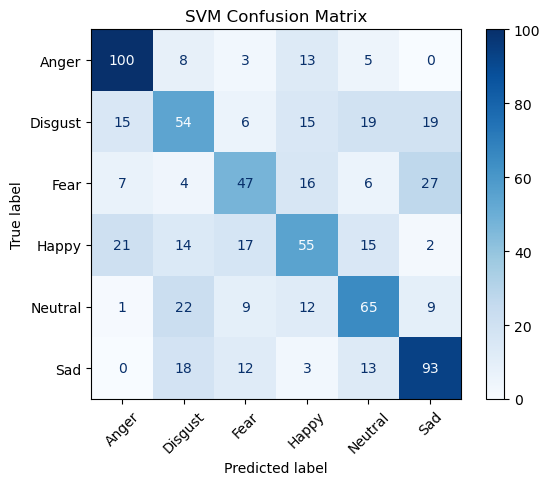

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have true labels for your test set in a variable y_test
# Load the true labels for the test set from the original test data if available
# y_test = pd.read_csv(r'C:\Users\rakes\Desktop\Machinelearn\test_data_with_emotion_labels.csv')['emotion']  # Load actual labels

# Display the classification report and accuracy score
print("Classification Report:")
print(classification_report(y_test, y_test_svm, target_names=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']))
print("Accuracy Score:", accuracy_score(y_test, y_test_svm))

# Plotting the confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_names, classifier="SVM"):
    confusion_mat = confusion_matrix(y_true, y_pred, labels=label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{classifier} Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

# Define label names for the emotions
label_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

# Plot the confusion matrix using the true labels and predictions
plot_confusion_matrix(y_test, y_test_svm, label_names=label_names, classifier="SVM")


In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load training and testing datasets
training_file_path = r'training_90.csv'
testing_file_path = r'test_10.csv'

# Load and preprocess the training data
training_data = pd.read_csv(training_file_path).drop(columns=['intensity'], errors='ignore')  # Remove 'intensity' if present
testing_data = pd.read_csv(testing_file_path).drop(columns=['intensity'], errors='ignore')  # Remove 'intensity' if present

# Separate features and target labels from the training data
training_features = training_data.drop(columns=['emotion']).values  # Extract feature columns
training_labels = training_data['emotion'].values  # Extract target column

# Extract features from the testing data
if 'emotion' in testing_data.columns:
    testing_features = testing_data.drop(columns=['emotion']).values  # Remove target if present
else:
    testing_features = testing_data.values  # Use all columns as features if 'emotion' is absent

# Handle missing values using mean imputation
mean_imputer = SimpleImputer(strategy='mean')
training_features = mean_imputer.fit_transform(training_features)
testing_features = mean_imputer.transform(testing_features)

# Standardize the features to have zero mean and unit variance
feature_scaler = StandardScaler()
training_features = feature_scaler.fit_transform(training_features)
testing_features = feature_scaler.transform(testing_features)

# Function to perform cross-validation with a Random Forest classifier
def validate_model(features, labels):
    rf_model = RandomForestClassifier(n_estimators=800, random_state=42)
    validation_scores = cross_val_score(rf_model, features, labels, cv=5, scoring='accuracy')  # 5-fold cross-validation
    print("Cross-Validation Scores:", validation_scores)
    print("Mean Cross-Validation Score:", validation_scores.mean())

# Perform cross-validation on the training data
validate_model(training_features, training_labels)

# Train the Random Forest model and make predictions on the test data
random_forest_model = RandomForestClassifier(n_estimators=800, random_state=42)
random_forest_model.fit(training_features, training_labels)
testing_predictions = random_forest_model.predict(testing_features)

# Save predictions to a CSV file
if 'new_id' in testing_data.columns:
    testing_data['emotion'] = testing_predictions  # Add predictions
    predictions_output = testing_data[['new_id', 'emotion']].rename(columns={"new_id": "id"})  # Rename column for clarity
else:
    predictions_output = pd.DataFrame({'id': testing_data.index, 'emotion': testing_predictions})  # Use index as ID

predictions_output.to_csv(r'C:\Users\rakes\Desktop\Machinelearn\predict_rf_final.csv', index=False)
print("Predictions saved to 'predict_rf_final.csv'")


Cross-Validation Scores: [0.52761194 0.50746269 0.49663928 0.48693055 0.50037341]
Mean Cross-Validation Score: 0.5038035736180932
Predictions saved to 'predict_rf_final.csv'


Classification Report:
              precision    recall  f1-score   support

       Anger       0.63      0.82      0.71       129
     Disgust       0.49      0.34      0.40       128
        Fear       0.52      0.30      0.38       107
       Happy       0.43      0.46      0.45       124
     Neutral       0.49      0.53      0.51       118
         Sad       0.57      0.70      0.63       139

    accuracy                           0.53       745
   macro avg       0.52      0.52      0.51       745
weighted avg       0.52      0.53      0.52       745

Accuracy Score: 0.5329


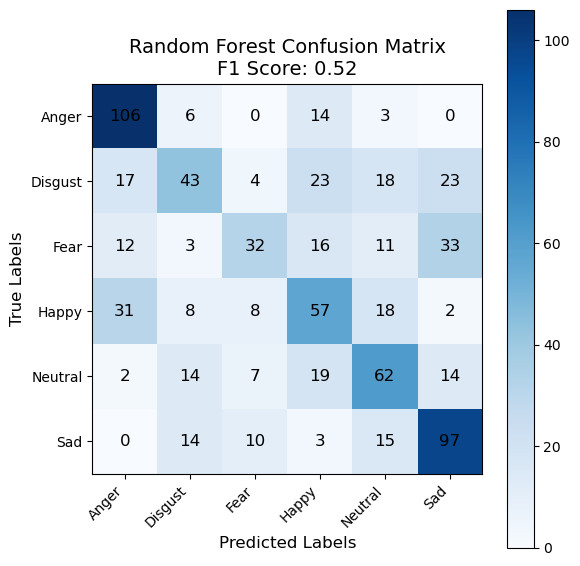

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import pandas as pd

# Load the test dataset
testing_file_path = r'test_10.csv'  # Update this to the correct file path
test_df = pd.read_csv(testing_file_path)  # Load the test dataset

# Ensure the 'emotion' column is available
if 'emotion' not in test_df.columns:
    raise ValueError("The 'emotion' column is missing from the test dataset. Ensure true labels are included.")

# Define a function to plot the confusion matrix with F1 score in the title
def plot_confusion_matrix_with_f1(y_true, y_pred, label_names, classifier="Random Forest"):
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    
    # Calculate the F1 score (weighted) and accuracy score
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Display the classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))
    print(f"Accuracy Score: {accuracy:.4f}")
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title(f"{classifier} Confusion Matrix\nF1 Score: {f1:.2f}", fontsize=14)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(np.arange(len(label_names)), label_names, rotation=45, ha='right')
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.colorbar()

    # Display counts in each cell of the confusion matrix
    for (i, j), label in np.ndenumerate(confusion_mat):
        plt.text(j, i, label, ha='center', va='center', fontsize=12, color="black")
    
    plt.tight_layout()
    plt.show()

# Extract true labels and predictions
true_testing_labels = test_df['emotion'].values  # True labels for the test set
predicted_labels_rf = testing_predictions  # Predicted labels from the Random Forest model

# Plot the confusion matrix with F1 score
plot_confusion_matrix_with_f1(
    y_true=true_testing_labels,
    y_pred=predicted_labels_rf,
    label_names=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],  # Adjust emotion labels as needed
    classifier="Random Forest"
)


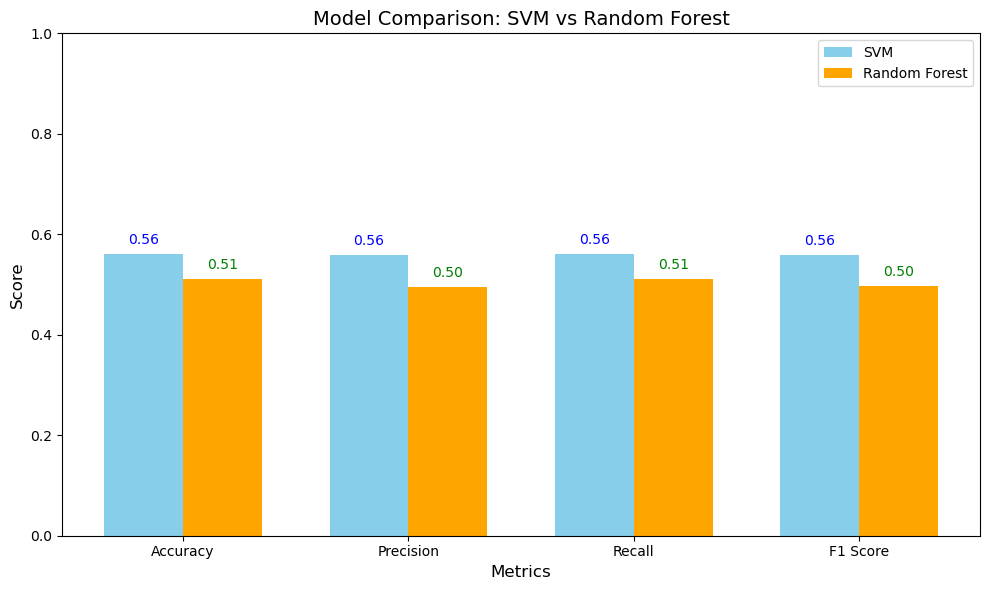

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_df, training_features, training_labels, and testing_features are defined

# Extract true labels for the test set
y_test = test_df['emotion'].values  # Ensure 'emotion' column exists in test_df

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Example SVM configuration
svm_model.fit(training_features, training_labels)  # Train SVM model

# Train the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Example RF configuration
random_forest_model.fit(training_features, training_labels)  # Train Random Forest model

# Generate predictions
y_test_svm = svm_model.predict(testing_features)  # Predictions from SVM model
y_test_rf = random_forest_model.predict(testing_features)  # Predictions from Random Forest model

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_test_svm)
svm_precision = precision_score(y_test, y_test_svm, average='weighted')
svm_recall = recall_score(y_test, y_test_svm, average='weighted')
svm_f1 = f1_score(y_test, y_test_svm, average='weighted')

# Calculate metrics for Random Forest
rf_accuracy = accuracy_score(y_test, y_test_rf)
rf_precision = precision_score(y_test, y_test_rf, average='weighted')
rf_recall = recall_score(y_test, y_test_rf, average='weighted')
rf_f1 = f1_score(y_test, y_test_rf, average='weighted')

# Prepare metrics for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
svm_scores = [svm_accuracy, svm_precision, svm_recall, svm_f1]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))

# Bars for SVM and Random Forest scores
plt.bar(index, svm_scores, bar_width, label='SVM', color='skyblue')  # SVM bars
plt.bar([i + bar_width for i in index], rf_scores, bar_width, label='Random Forest', color='orange')  # RF bars

# Annotating the plot
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Comparison: SVM vs Random Forest', fontsize=14)
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.ylim(0, 1)  # Assuming all metrics are scaled between 0 and 1
plt.legend()

# Display values on top of bars
for i, (svm_score, rf_score) in enumerate(zip(svm_scores, rf_scores)):
    plt.text(i, svm_score + 0.02, f"{svm_score:.2f}", ha='center', color='blue', fontsize=10)
    plt.text(i + bar_width, rf_score + 0.02, f"{rf_score:.2f}", ha='center', color='green', fontsize=10)

# Finalize and display the plot
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
from scipy.stats import f_oneway

# Load the data (replace with your file path if needed)
file_path = 'audio_features_emotions.csv'
data = pd.read_csv(file_path)

# Extract features and emotion labels
mfcc_features = data.filter(regex="^mfcc_")
emotion_labels = data["emotion"].unique()

# Results dictionary to store ANOVA results
anova_within_emotions_results = {"Emotion": [], "Feature_Group": [], "F-statistic": [], "p-value": []}

# Perform ANOVA within each emotion group
for emotion in emotion_labels:
    # Hypotheses for this emotion group
    print(f"\nAnalyzing Emotion Group: {emotion}")
    print("Null Hypothesis (H0): The mean values of all features are the same within this emotion group.")
    print("Alternative Hypothesis (H1): At least one feature has a different mean value within this emotion group.\n")
    
    # Subset data for the current emotion group
    emotion_data = data[data["emotion"] == emotion]
    emotion_features = emotion_data[mfcc_features.columns]
    
    # Transpose the features: rows represent features, columns represent instances
    transposed_emotion_features = emotion_features.T
    
    # Perform one-way ANOVA
    try:
        # Perform ANOVA across all features within this emotion group
        f_stat, p_value = f_oneway(*transposed_emotion_features.values)
        
        # Store results
        anova_within_emotions_results["Emotion"].append(emotion)
        anova_within_emotions_results["Feature_Group"].append("MFCC Features")
        anova_within_emotions_results["F-statistic"].append(f_stat)
        anova_within_emotions_results["p-value"].append(p_value)
        
        # Print results for this emotion group
        print(f"F-statistic: {f_stat}")
        print(f"p-value: {p_value}")
        if p_value < 0.05:
            print("Conclusion: Reject the null hypothesis. Significant differences exist among the features.\n")
        else:
            print("Conclusion: Fail to reject the null hypothesis. No significant differences among the features.\n")
    except Exception as e:
        # Handle any errors gracefully
        print(f"Error analyzing {emotion}: {e}")
        anova_within_emotions_results["Emotion"].append(emotion)
        anova_within_emotions_results["Feature_Group"].append("MFCC Features")
        anova_within_emotions_results["F-statistic"].append(None)
        anova_within_emotions_results["p-value"].append(None)

# Convert results to a DataFrame
anova_within_emotions_results_df = pd.DataFrame(anova_within_emotions_results)

# Save results to a CSV file (optional)
anova_within_emotions_results_df.to_csv("anova_within_emotions_results.csv", index=False)

# Display summary of all results
print("\nSummary of ANOVA Results Across All Emotion Groups:")
print(anova_within_emotions_results_df)



Analyzing Emotion Group: Anger
Null Hypothesis (H0): The mean values of all features are the same within this emotion group.
Alternative Hypothesis (H1): At least one feature has a different mean value within this emotion group.

F-statistic: 62922.05046818532
p-value: 0.0
Conclusion: Reject the null hypothesis. Significant differences exist among the features.


Analyzing Emotion Group: Disgust
Null Hypothesis (H0): The mean values of all features are the same within this emotion group.
Alternative Hypothesis (H1): At least one feature has a different mean value within this emotion group.

F-statistic: 87624.26938220189
p-value: 0.0
Conclusion: Reject the null hypothesis. Significant differences exist among the features.


Analyzing Emotion Group: Fear
Null Hypothesis (H0): The mean values of all features are the same within this emotion group.
Alternative Hypothesis (H1): At least one feature has a different mean value within this emotion group.

F-statistic: 62222.040920505475
p-va